<center>

## MAGICIAN: Mining and gAmblinG servIces sCrapIng and ANalysis

Matteo Martini 636694

### Setup Ambiente

In [122]:
import pandas as pd

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

import numpy as np

import time
import requests
import re
from bs4 import BeautifulSoup

print('Environment ready.')

Environment ready.


### 1 Lettura dal Dataset

In [123]:
dataset_path = "./Datasets/"
def load_datasets(dataset_path):
    transactions = pd.read_csv(dataset_path + 'transactions.csv',header=None)
    inputs    = pd.read_csv(dataset_path +'inputs.csv',header=None)
    outputs   = pd.read_csv(dataset_path + 'outputs.csv',header=None)
    mapping   = pd.read_csv(dataset_path + 'mapAddr2Ids8708820.csv',header=None)
    return inputs,outputs,transactions,mapping

print("Loading data...")
inputs_df, outputs_df,transactions,mapping_df = load_datasets(dataset_path)
print("Done!")


Loading data...
Done!


### 1.1. Preprocessing
#### Aggiunta colonne e downscaling dei tipi
La prima cosa evidente quando leggo questi CSV, è che non è presente il column name nei file, dunque per comodità, seguendo la traccia li aggiungerò io.

In aggiunta, downscalerò i tipi default (np.int64) alla minore grandezza possibile, così da risparmiare memoria e quindi tempo nelle operazioni.

In [124]:
print("Adding headers to the dataframes")
transactions.columns = ["timestamp", "block_height", "tx_id", "is_coinbase", "fee"]
# headers mapping
mapping_df.columns = ["hash","addressId" ]
# headers inputs
inputs_df.columns = ["tx_id", "prev_tx_id", "prev_tx_pos"]
# headers outputs
outputs_df.columns = ["tx_id", "position", "addressId", "amount", "script_type"]
print("Done...")

# In aggiunta, andrò a downcastare ad int16 i campi che posso, escudendo i campi sui quali verrà effettuato un merge.
# Questo downcast è possibile in quanto i valori presenti nei campi sono tutti numeri interi
# Andrà in automatico al valore minimo possibile per quel campo
print("Downcasting data...")
# # Transactions
transactions['timestamp'] = pd.to_numeric(transactions['timestamp'], downcast='integer')
transactions['block_height'] = pd.to_numeric(transactions['block_height'], downcast='integer')
# transactions['tx_id'] = pd.to_numeric(transactions['tx_id'], downcast='integer')
transactions['fee'] = pd.to_numeric(transactions['fee'], downcast='integer')

# Convert isCoinbase to categorical if it's binary
transactions['is_coinbase'] = transactions['is_coinbase'].astype('category')

# # Inputs
# inputs_df['tx_id'] = pd.to_numeric(inputs_df['tx_id'], downcast='integer')
# inputs_df['prev_tx_id'] = pd.to_numeric(inputs_df['prev_tx_id'], downcast='integer')
# inputs_df['prev_tx_pos'] = pd.to_numeric(inputs_df['prev_tx_pos'], downcast='integer')

# # Outputs
# outputs_df['tx_id'] = pd.to_numeric(outputs_df['tx_id'], downcast='integer')
# outputs_df['position'] = pd.to_numeric(outputs_df['position'], downcast='integer')
# outputs_df['addressId'] = pd.to_numeric(outputs_df['addressId'], downcast='integer')
outputs_df['amount'] = pd.to_numeric(outputs_df['amount'], downcast='integer')
outputs_df['script_type'] = outputs_df['script_type'].astype('category')
# print("Done...")

Adding headers to the dataframes
Done...
Downcasting data...


#### Filtro per le transazioni invalide
Prima di continuare con le analisi e lo scraping dei dati, è importantissimo controllare che le transazioni che abbiamo nel dataset siano valide.
In particolare ci interessa controllare:
 - Che non ci siano input o output che non fanno riferimento ad una transazione reale
 - Input che fanno riferimento a transazioni non esistenti (quindi spendi btc non esistenti)
 - Output con "amount" negativi
 - Transazioni con fees negative
 - Double spending transactions
 - Transazioni con lo stesso id

In [125]:
invalidInput = inputs_df[~ inputs_df.tx_id.isin(transactions['tx_id'])] #Input che non hanno un txId corrispondente in transactions
invalidOutput = outputs_df[~ outputs_df.tx_id.isin(transactions['tx_id'])] #Output che non hanno un txId corrispondente in transactions

print("Invalid inputs: ", invalidInput.shape[0])
print("Invalid outputs: ", invalidOutput.shape[0])
# Sono entrambi vuoti, quindi non ci sono input o output che non hanno un txId corrispondente in transactions (le transazioni sono dunque valide da questo punto di vista)

# Input che non hanno un prevTxId corrispondente in outputs
invalidPrevTxId = inputs_df[~ inputs_df.prev_tx_id.isin(outputs_df['tx_id'])]
print("Invalid prevTxId: ", invalidPrevTxId.shape[0])
# Anche qui sono 0

# Output con amount negativi
invalidAmount = outputs_df[outputs_df.amount < 0]
print("Invalid amount: ", invalidAmount.shape[0])

# Fees negative 
invalidFees = transactions[transactions.fee < 0]
print("Invalid fees: ", invalidFees.shape[0])

# Double spending transactions
double_spending = inputs_df[['tx_id', 'prev_tx_id', 'prev_tx_pos']].merge(transactions[['tx_id', 'timestamp']].astype('int64'), on='tx_id', how='left')
double_spending['group_count'] = double_spending.groupby(['prev_tx_id', 'prev_tx_pos'])['tx_id'].transform('count')
double_spending = double_spending[double_spending['group_count'] > 1]
double_spending.drop(columns=['group_count'], inplace=True)

print("Double spending transactions: ", double_spending.shape[0])


# Same id transactions
same_id = transactions['tx_id'].value_counts()
same_id = same_id[same_id > 1]

print("Same id transactions: ", same_id.shape[0])

Invalid inputs:  0
Invalid outputs:  0
Invalid prevTxId:  0
Invalid amount:  0
Invalid fees:  0
Double spending transactions:  0
Same id transactions:  2


Sfortunatamente quello che notiamo è che esistono due txId che sono correlati a più transazioni. Quello che facciamo allora è eliminarle da transactions, inputs e outputs.

In [126]:
# i txId sono già in same_id, basta semplicemente rimuoverle controllando se il txId è presente nell'index di same_id
transactions = transactions[~ transactions.tx_id.isin(same_id.index)]
inputs = inputs_df[~ inputs_df.tx_id.isin(same_id.index)]
outputs = outputs_df[~ outputs_df.tx_id.isin(same_id.index)]

Adesso che abbiamo effettuato questo passo di preprocessing, non ci sono altre transazioni che risultano invalide, dunque possiamo procedere ad unire output con mapping èer avere una maniera più agevole per accedere agli indirizzi hashati

In [127]:
merged_outputs = outputs_df.merge(mapping_df,on="addressId",how="left")
# display(merged_outputs)

In [128]:
wallet_explorer_url = "https://www.walletexplorer.com/"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/",
}

headers_address = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/address/",
}


### Definizione Funzioni Helper per Scraping

In [129]:
def next_page(driver):
    #cerco il link alla prossima pagina
    for _ in ("Next","Last"):
        try:
            el = driver.find_element(By.XPATH, f'//div[@class="paging"]//a[contains(., "{_}")]')
            url = el.get_attribute("href")
            el.click()
            return url
        except:
            return None
        
def find_next_link(driver,element):
    try:
        el = driver.find_element(By.XPATH, f'//span[@class="showother"]//a[contains(., "{element}")]')
        url = el.get_attribute("href")
        el.click()
        return url
    except:
        return None

def scrape_step(driver):
    #recupero le entries
    soup = BeautifulSoup(driver.page_source, "html.parser")
    # seleziona tutti gli elementi che hanno l’attributo data-wallet-id
    wallet_elements = soup.select("td a[href^='/address/']") 
    # estrai il valore dell’attributo
    return [re.search(r"/address/([^/?#]+)", w.get("href")).group(1) for w in wallet_elements if w.get("href") and re.search(r"/address/([^/?#]+)", w.get("href"))]




### Definizione Funzione per Scraping

In [130]:
def scrape_wallet_explorer(wallet_name):
    driver = webdriver.Chrome()
    driver.get(wallet_explorer_url)
    
    #ricerca del wallet tramite form
    driver.find_element(By.NAME,'q').send_keys(wallet_name)
    driver.find_element(By.TAG_NAME,'form').submit()
    
    #mettere funzione di selenium
    time.sleep(1)
    
    #mostra wallet
    clicked = find_next_link(driver,"show wallet addresses")
    if clicked == None: return
    #mettere funzione di selenium
    time.sleep(1)

    try:
        while True:
            #recupero di tutti gli input/output della pagina
            yield from scrape_step(driver)
            if next_page(driver) == None:break;
    except:
            print('Something went wrong')
    finally:
        driver.close()


<center>

## Data Retrieval

Per comodità ed oridne andremo a recuperare da subito tutti gli indirizzi da WalletExplorer

In [131]:
deepbit_transactions = set(scrape_wallet_explorer('DeepBit.net'))
diceoncrack_addresses = set(scrape_wallet_explorer('DiceonCrack'))




### Preparazione Dataframe

#### Dataframe Deepbit.net

In [132]:
#Memorizzo l'hash degli indirizzi di DeepBit.net
deepbit_hased_addresses = set(mapping_df[mapping_df["hash"].isin(deepbit_transactions)]["addressId"])

#Output di DeepBit
bnet_out = merged_outputs[merged_outputs["hash"].isin(deepbit_transactions)]
deepbit_out_transactions = transactions[transactions["tx_id"].isin(bnet_out["tx_id"].unique())]
assert len(deepbit_out_transactions) > 0

#Transazioni CoinBase


# transazioni che inviano a Deepbit     
deepbit_trans_id = deepbit_out_transactions["tx_id"].unique()
# display(deepbit_trans_id)

deepbit_inputs = inputs_df[inputs_df["tx_id"].isin(deepbit_trans_id)]
# display(deepbit_inputs)

mask_tx = transactions["tx_id"].isin(deepbit_inputs["prev_tx_id"].tolist())
mask_cb = transactions["is_coinbase"] == 1 

coinbase_deepb = transactions[mask_tx & mask_cb].copy()

#Fee Minatori
#Amount singole transazioni
outputs_indexed = outputs_df.rename(columns={"tx_id":"prev_tx_id","position":"prev_tx_pos"}).set_index(['prev_tx_id', 'prev_tx_pos'])
inputs_indexed = inputs_df.set_index(['prev_tx_id', 'prev_tx_pos'])

amounts = inputs_indexed.join(outputs_indexed, how='inner', rsuffix='_output')
amounts = amounts.reset_index()

input_amount = amounts.groupby('tx_id')["amount"].sum().rename('input_total')
output_amount = outputs_df.groupby('tx_id')['amount'].sum().rename('output_total')
#Calcolo Fee
fees = pd.concat([input_amount,output_amount],axis=1)
fees['fee'] = fees['input_total'] - fees['output_total']
fees = fees.reset_index().rename(columns={'index':'tx_id'})
fees = fees.merge(
    transactions[['tx_id', 'is_coinbase', 'block_height']],
    on='tx_id',
    how='left'
)
not_coinbase = fees["is_coinbase"] == 0
fees = fees[not_coinbase]
fee_per_block = fees.groupby('block_height')['fee'].sum().reset_index()


#Calcolo UTXO

amounts_indexed = amounts[['prev_tx_id', 'prev_tx_pos']].set_index(['prev_tx_id', 'prev_tx_pos'])

diff = outputs_indexed.join(
    amounts_indexed,
    how='left',
    rsuffix='_right'
)

# Semplicemente controlla se l'indice è presente
diff['_merge'] = 'left_only'
diff.loc[diff.index.isin(amounts_indexed.index), '_merge'] = 'both'

diff = diff.reset_index().rename(columns={"prev_tx_id":"tx_id","prev_tx_pos":"position"})

unspent_df = diff[diff['_merge'] == 'left_only'].copy()

#Trasformazione Timestamp
UTXO_df = unspent_df.merge(transactions,how="left",on="tx_id")[["amount","timestamp"]]
UTXO_df["timestamp"] = pd.to_datetime(UTXO_df["timestamp"],unit="s")
UTXO_df = UTXO_df.set_index("timestamp")

#### Dataframe DiceOnCrack

In [133]:
doc_outs = merged_outputs[merged_outputs["hash"].isin(diceoncrack_addresses)]

doc_inputs  = inputs_df.merge(doc_outs[["tx_id","position","addressId"]].rename(columns={"tx_id":"prev_tx_id","position":"prev_tx_pos"}),how="inner",on=["prev_tx_id","prev_tx_pos"])

doc_trans_id =  np.union1d(doc_inputs["tx_id"].unique(),doc_outs["tx_id"].unique())

doc_trans = transactions[transactions["tx_id"].isin(doc_trans_id)].sort_values("block_height")

doc_trans["timestamp"] = pd.to_datetime(doc_trans["timestamp"],unit='s')

<center>

# Analisi Transazioni di DeepBit.Net

### Considerazione dell'attività nel tempo

In [134]:
coinbase_deepb["timestamp"] = pd.to_datetime(coinbase_deepb["timestamp"],unit="s")
coinbase_deepb = coinbase_deepb.set_index("timestamp")
# display(coinbase_deepb)

<Axes: title={'center': 'Blocchi minati da Deepbit.net per mese'}, xlabel='timestamp'>

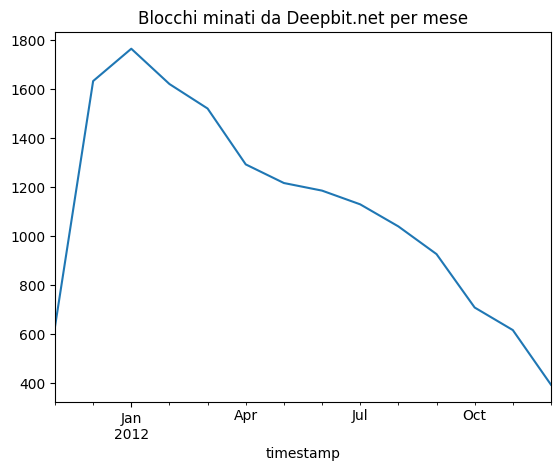

In [135]:
# Numero di transazioni per mese
monthly_counts = coinbase_deepb.resample('ME').size()
monthly_counts.plot(title='Blocchi minati da Deepbit.net per mese')

<Axes: title={'center': 'Blocchi minati da Deepbit.net per settimana'}, xlabel='timestamp'>

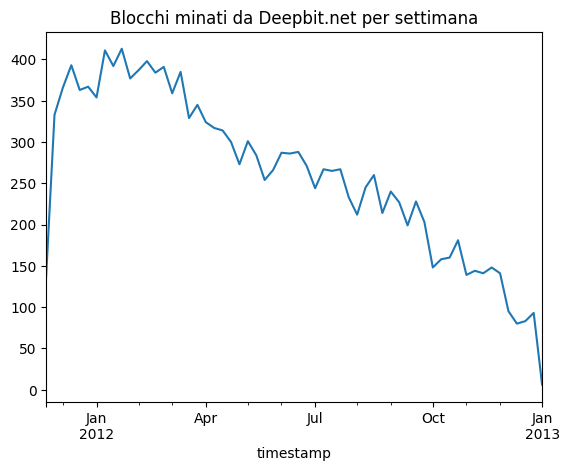

In [136]:
# Numero di transazioni per mese
weekly_counts = coinbase_deepb.resample('W').size()
weekly_counts.plot(title='Blocchi minati da Deepbit.net per settimana')

C:\Users\matte\AppData\Local\Temp\ipykernel_5952\524359246.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_counts = coinbase_deepb.resample('Y').size()


<Axes: title={'center': 'Blocchi minati da Deepbit.net per anno'}, xlabel='timestamp'>

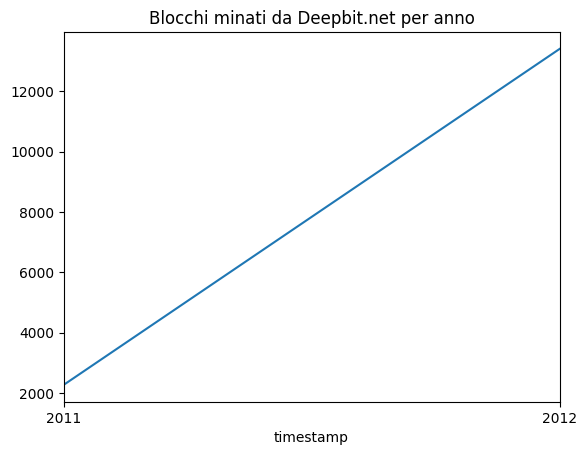

In [137]:
# Numero di transazioni per mese
yearly_counts = coinbase_deepb.resample('Y').size()
yearly_counts.plot(title='Blocchi minati da Deepbit.net per anno')

## 3)Analisi degli UTXO(Unspent Transaction Output)

C:\Users\matte\AppData\Local\Temp\ipykernel_5952\3483965704.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  monthly_UTXO = UTXO_df.resample('Y').size()


<Axes: title={'center': 'UTXO per anni'}, xlabel='timestamp'>

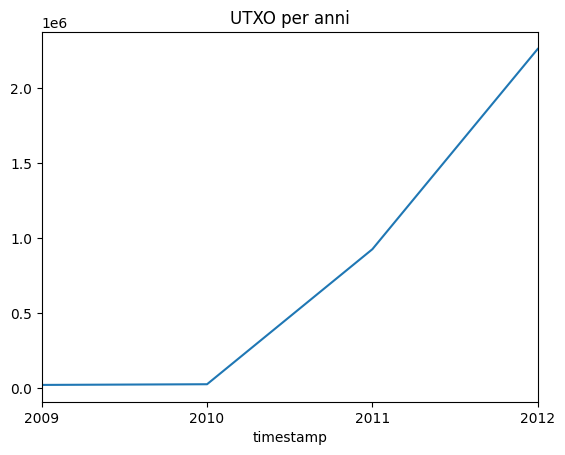

In [138]:
# Numero di transazioni per mese
monthly_UTXO = UTXO_df.resample('Y').size()
monthly_UTXO.plot(title='UTXO per anni')

### Analisi Catena Transazioni a partire dalla transazione tx_id = 1883820

In [139]:
# deepbit_hased_addresses = set(mapping_df[mapping_df["hash"].isin(deepbit_transactions)]["addressId"])

root_transaction = transactions[transactions["tx_id"] == 1883820];
root_output = outputs_df[outputs_df["tx_id"] == 1883820]

#### Definizione Funzioni per ricostruire la catena di transazioni 

In [140]:
def find_input(output_tx_id,output_position):
    tx_id_mask = inputs_df["prev_tx_id"]== output_tx_id
    tx_pos_mask = inputs_df["prev_tx_pos"]==output_position
    
    #cerco il prossimo input della catena
    next = inputs_df[tx_id_mask & tx_pos_mask ]
    
    return int(next.iloc[0]["tx_id"]) 

def find_related_outputs(output_tx_id,output_position):

    next_tx_id = find_input(output_tx_id,output_position)
    #maschere per ottenere l'output
    outputs_tx_id_mask = outputs_df["tx_id"] == (next_tx_id)
    
    return outputs_df[ outputs_tx_id_mask ]

def separate_addresses(address_list, address_set):
    matches = []
    others = []
    for address in address_list:
        if address in address_set:
            matches.append(address)
        else:
            others.append(address)
    return matches, others

def chain_transactions(chain_output):
    othersDeepbit = []
    change_addresses_transactions = []
    change_addresses = []
    while True:
        #cerco gli output
        related_outputs = find_related_outputs(chain_output["tx_id"],chain_output["position"])
        #Separo gli indirizzi
        deepbit_matches,others = separate_addresses(related_outputs["addressId"],deepbit_hased_addresses)
        #estendo othersDeepbit per poterlo ritornare
        othersDeepbit.extend(others)

        if len(deepbit_matches) != 1:break
        
        #ricavo il prossimo output
        chained = related_outputs[related_outputs["addressId"] == deepbit_matches[0]].iloc[0]
        change_addresses.append(int(chained["tx_id"]))
        #memorizzo il tx_id per poter riutilizzare le transazioni
        change_addresses_transactions.append(
            {
                "tx_id":      int(chained["tx_id"]),
                "position":   int(chained["position"]),
                "addressId":  int(chained["addressId"]),
                "amount":     float(chained["amount"])
            }
        )
        chain_output = chained
    
    return change_addresses,change_addresses_transactions,othersDeepbit

### ricostruisco la catena

In [141]:
ctx,change_addresses_transactions,othersDeepbit = chain_transactions(root_output.iloc[0])

## Rappresentazione della catena mediante grafo

In [142]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
chain_tx_ids = ctx
print(len(chain_tx_ids)/2)
differences =[]
# aggiungo archi tra tx consecutive
for i in range(len(change_addresses_transactions) - 1):
    t1 = f't{i+1}'
    t2 = f't{i+2}'
    stamp1 = int(transactions[transactions["tx_id"] == change_addresses_transactions[i]["tx_id"]].iloc[0]["timestamp"])
    stamp2 = int(transactions[transactions["tx_id"] == change_addresses_transactions[i+1]["tx_id"]].iloc[0]["timestamp"])
    dt = stamp1 - stamp2
    da = change_addresses_transactions[i]["amount"] - change_addresses_transactions[i+1]["amount"]
    
    if dt < 0 : dt *= -1 

    differences.append({"delta_time":dt,"delta_amount":da})
    
    G.add_edge(t1, t2,label = change_addresses_transactions[i]["amount"])



34.5


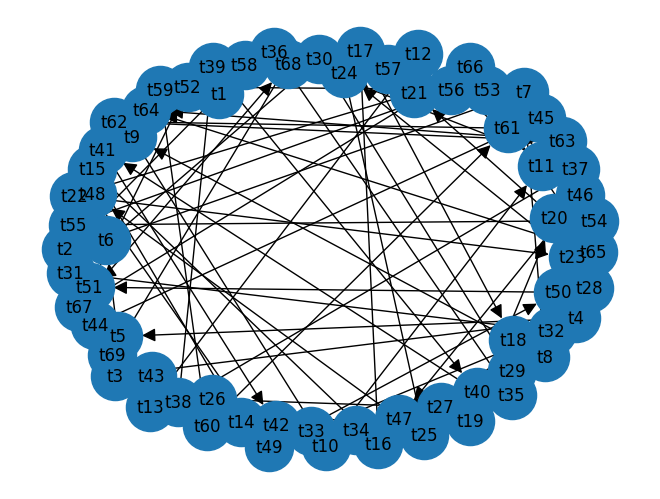

In [143]:
pos = nx.spring_layout(G, k=1000000000000000)

nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)
plt.show()

## Grafico Descrittivo

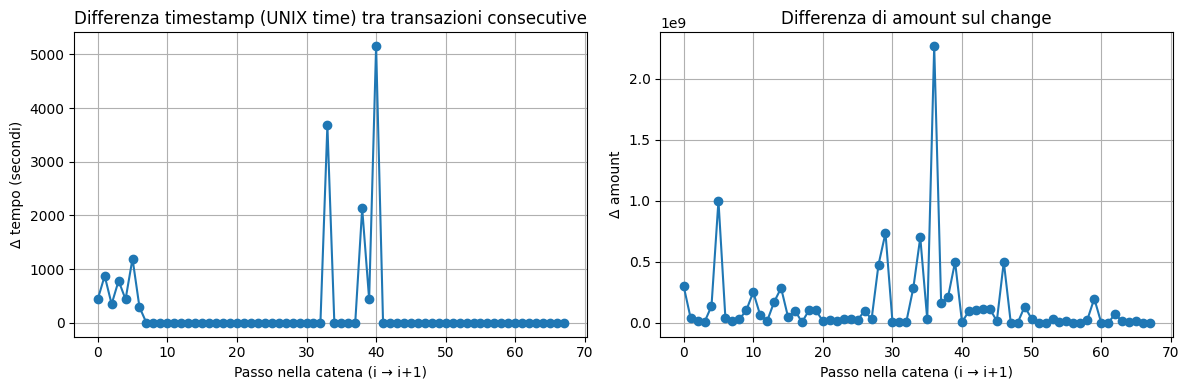

In [144]:
import matplotlib.pyplot as plt

diffs_df = pd.DataFrame(differences)
x = range(len(diffs_df))

plt.figure(figsize=(12,4))

# Δ tempo
plt.subplot(1,2,1)
plt.plot(x, diffs_df["delta_time"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ tempo (secondi)")
plt.title("Differenza timestamp (UNIX time) tra transazioni consecutive")
plt.grid(True)

# Δ amount
plt.subplot(1,2,2)
plt.plot(x, diffs_df["delta_amount"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ amount")
plt.title("Differenza di amount sul change")
plt.grid(True)

plt.tight_layout()
plt.show()


## Secondo passo di scraping da WalletExplorer per individuare indirizzi deanonimizzati

In [145]:
def is_deanonimizzato(wallet_name):
    w = wallet_name.lower()
    # 1) se contiene un dominio → servizio reale
    if any(ext in w for ext in [".com", ".net", ".org", ".io"]):
        return True
    
    # 2) se è uno dei servizi noti → deanonimizzato
    known = ["deepbit", "diceoncrack", "mtgox", "bitcoinmarket", "slush", "bitminter"]
    if any(k in w for k in known):
        return True
    
    # se non rientra nei casi sopra → NON deanonimizzato
    return False

def identify_address(address):
    res = requests.get(f'{wallet_explorer_url}/address/{address}',headers=headers_address)
    soup = BeautifulSoup(res.text,"html.parser")
    wallet_name = soup.select_one('span.wallet_name').text
    
    match = re.search(r"\[(.*?)\]", wallet_name)
    
    if match:
        wallet_name = match.group(1)

    return wallet_name;

In [146]:
othersDeepbit = [mapping_df[mapping_df["addressId"] == address].iloc[0]["hash"] for address in othersDeepbit]
others_deanon = [is_deanonimizzato(identify_address(address)) for address in othersDeepbit]

In [147]:
print(len(others_deanon))
deanonized = set(address for address in others_deanon if address == True)
print(deanonized)

70
{True}


### Riflessione sui risultati

Effettuando lo scraping degli indirizzi contenuti nell’insieme OthersDeepbit, solo un indirizzo risulta associato a un wallet deanonimizzato su WalletExplorer.

Questo risultato è coerente con il periodo storico del dataset (2009–2012), in cui la maggior parte degli indirizzi apparteneva a utenti privati e WalletExplorer era in grado di identificare solo alcuni grandi servizi pubblici (exchange, mining pool, gambling, merchant).

Gli indirizzi esterni che compaiono nella catena di pagamenti di Deepbit rappresentano prevalentemente utenti individuali della mining pool, che generavano nuovi indirizzi ad ogni transazione e non lasciavano tracce pubbliche della loro identità.

Il fatto che quasi tutti i wallet rimangano anonimi conferma quindi che la catena analizzata non coinvolge servizi pubblici noti e che WalletExplorer non dispone di informazioni sufficienti per collegare questi indirizzi a entità reali.

<center>

  # Analisi del servizio di gambling

#### Definizione Funzioni Per analisi

In [153]:
def height_mask(height,desired_day_trans): return desired_day_trans["block_height"] == height 

def map_outputs_mask(input): return (merged_outputs["tx_id"] == input["prev_tx_id"]) & (merged_outputs["position"] == input["prev_tx_pos"])

def all_tx_inputs(txs): 
    return [
            merged_outputs[map_outputs_mask(trans)].iloc[0]["hash"] 
                for tx in txs 
                    for _,trans in inputs_df[inputs_df["prev_tx_id"] == tx].iterrows()
            ]

#ha lo scopo di ridurre lo scraping fornendo un dizionario per "tradurre" gli indirizzi in maniera più veloce
def retireve_address_translation_dict(set): return { entry:identify_address(entry) for entry in set }

# print(wallet_address_dict)
def translate_addresses(translation_dict,address_list): return [translation_dict[address] for address in address_list]

def index_block_addresses(same_heights,translation_dict):
    translated = {}
    for key in same_heights:
        for _ in same_heights[key]:
            translated[key] = translate_addresses(translation_dict,same_heights[key])
    return translated


def clusterize(cluster,data):
    for wallet in data:
        if wallet not in cluster:
            cluster[wallet] = 1
        else:
            cluster[wallet] +=1

def create_clusters(data):
    cluster = {}
    for block_height in data:
        
        cluster[block_height] = {}
        clusterize(cluster[block_height],data[block_height])
    return cluster

def cluster_mean(clusters):
    result = {}
    for block in clusters:
        i = 0
        mean = 0 
        for cluster in clusters[block]:
            dim = clusters[block][cluster]
            if cluster == "DiceOnCrack.com": continue
            if dim<2:continue
            i+=1
            mean+=dim
        if i<= 0: continue 
        mean = mean/i
        result[block] = f'num cluster: {i}, mean:{mean}'
        mean = 0
        i = 0
    return result

#### Controllo le transazioni di un determinato intervallo temporale, dividendole in base al block_height e soprattutto ricavando il loro addressId, con accorgimenti per rendere più light lo scraping

In [149]:
# Crea un range di date
date_range = pd.date_range(start="2012-12-26", end="2012-12-27", freq='D').date
# Filtra usando isin
desired_day_trans = doc_trans[doc_trans["timestamp"].dt.date.isin(date_range)]

unique_heights = desired_day_trans["block_height"].unique().tolist()

same_heights = {height:all_tx_inputs(desired_day_trans[height_mask(height,desired_day_trans)]["tx_id"].tolist()) for height in unique_heights}

#### Individuazione ed Analisi dei Cluster

In [150]:
#ottengo indirizzi unici per ridurre l'impatto dello scraping
unique_addresses = set(addr for key in same_heights for addr in same_heights[key])

address_translation_dict = retireve_address_translation_dict(unique_addresses)
# wallet_address_dict = retireve_wallet_addresses(wall)
wallet_addresses = index_block_addresses(same_heights,address_translation_dict)

print(len(wallet_addresses))
#il 26 = 13
#dal 26 al 27 = 43
clusterized_wallets = create_clusters(wallet_addresses)

cluster_dict = cluster_mean(clusterized_wallets)

print(len(cluster_dict))

display(cluster_dict)
#il 26 = 6
#dal 26 al 27 = 31
#dal 26 al 30 = 45

43
31


{213645: 'num cluster: 1, mean:2.0',
 213651: 'num cluster: 1, mean:3.0',
 213653: 'num cluster: 1, mean:2.0',
 213654: 'num cluster: 2, mean:2.5',
 213659: 'num cluster: 1, mean:3.0',
 213739: 'num cluster: 1, mean:2.0',
 213780: 'num cluster: 1, mean:3.0',
 213789: 'num cluster: 1, mean:18.0',
 213790: 'num cluster: 1, mean:18.0',
 213792: 'num cluster: 1, mean:7.0',
 213800: 'num cluster: 1, mean:3.0',
 213805: 'num cluster: 1, mean:8.0',
 213812: 'num cluster: 1, mean:2.0',
 213841: 'num cluster: 1, mean:6.0',
 213842: 'num cluster: 1, mean:6.0',
 213843: 'num cluster: 1, mean:6.0',
 213844: 'num cluster: 1, mean:2.0',
 213865: 'num cluster: 1, mean:2.0',
 213897: 'num cluster: 2, mean:3.0',
 213898: 'num cluster: 1, mean:2.0',
 213899: 'num cluster: 1, mean:2.0',
 213901: 'num cluster: 1, mean:4.0',
 213903: 'num cluster: 1, mean:4.0',
 213904: 'num cluster: 1, mean:7.0',
 213905: 'num cluster: 1, mean:3.0',
 213907: 'num cluster: 1, mean:2.0',
 213909: 'num cluster: 1, mean:6.0',

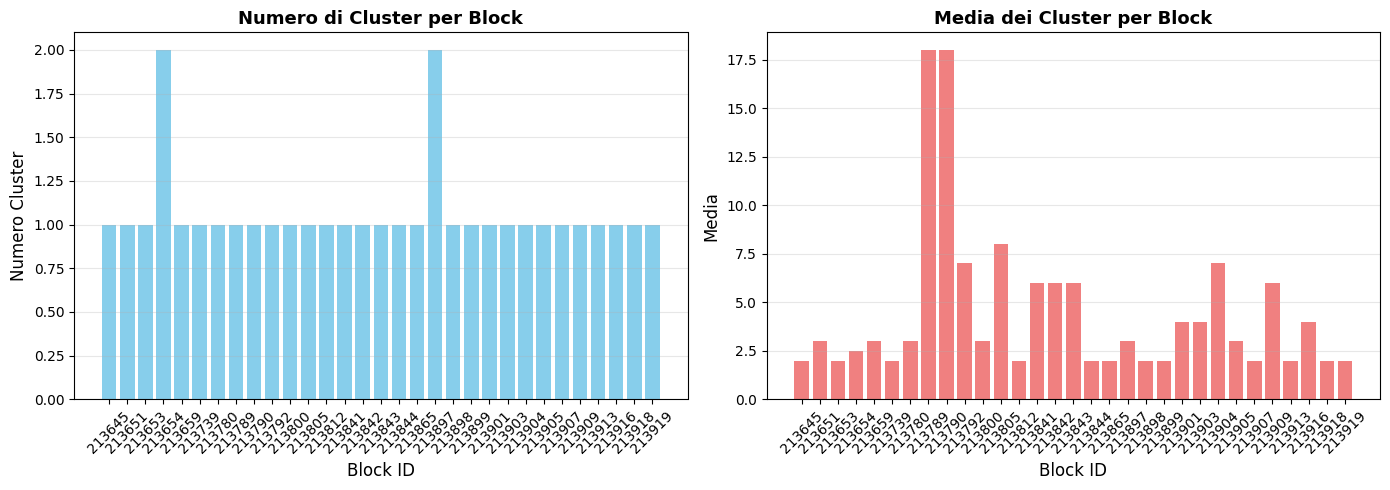

In [154]:
import matplotlib.pyplot as plt


data = cluster_dict
# Estrazione dei dati (stesso di prima)
block_ids = [k for k in data.keys()]
num_clusters = []
means = []

for value in data.values():
    parts = value.split(', ')
    num_cluster = int(parts[0].split(':')[1].strip())
    mean = float(parts[1].split(':')[1].strip())
    num_clusters.append(num_cluster)
    means.append(mean)

# Creazione di due subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Primo grafico: Numero di cluster
ax1.bar(range(len(block_ids)), num_clusters, color='skyblue')
ax1.set_xlabel('Block ID', fontsize=12)
ax1.set_ylabel('Numero Cluster', fontsize=12)
ax1.set_title('Numero di Cluster per Block', fontsize=13, fontweight='bold')
ax1.set_xticks(range(len(block_ids)))
ax1.set_xticklabels(block_ids, rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Secondo grafico: Media
ax2.bar(range(len(block_ids)), means, color='lightcoral')
ax2.set_xlabel('Block ID', fontsize=12)
ax2.set_ylabel('Media', fontsize=12)
ax2.set_title('Media dei Cluster per Block', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(block_ids)))
ax2.set_xticklabels(block_ids, rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Discussione su comportamento dei gambler